<a href="https://colab.research.google.com/github/wyn071/Novel-Analyzer-with-NLP/blob/main/Novel_Analyzer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part I - Installations, Imports, and Data Loading

In [ ]:
# Installing libraries
!pip install pdfminer.six # for text extraction
!pip install sumy # for summarization

In [ ]:
# Imports
import nltk

# Downloading required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')

import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import random
import textwrap
from pdfminer.high_level import extract_text
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from collections import Counter
from wordcloud import WordCloud
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lsa import LsaSummarizer
from sklearn.feature_extraction.text import TfidfVectorizer

Downloading The Social Cancer (full pdf)

In [ ]:
!wget -O the_social_cancer.pdf "https://drive.google.com/uc?export=download&id=1RWL606VM86mX5fSJeCrVByg9fW5lh59H"

Extracting text from Chapter 27 (my assigned chapter)

In [ ]:
chap27_full_text = extract_text(
    "the_social_cancer.pdf",
    page_numbers=range(249, 256) # Chapter 27 encompasses pages 250-256
)

Quick checking the first 500 chars from extracted chapter


In [ ]:
print(chap27_full_text[:500])

C       XXVII

I      T       

In Capitan Tiago’s house also great preparations had been made.
We know its owner, whose love of ostentation and whose pride as a
Manilan imposed the necessity of humiliating the provincials with his
splendor. Another reason, too, made it his duty to eclipse all others:
he had his daughter Maria Clara with him, and there was present his
future son-in-law, who was attracting universal attention.

In fact one of the most serious newspapers in Manila had devoted

to 


Removing the chapter heading & title, and keeping the body only

In [ ]:
chap27_body = chap27_full_text.split("\n\n", 2)[2]

Checking the chapter body

In [ ]:
print(chap27_body[:397])

In Capitan Tiago’s house also great preparations had been made.
We know its owner, whose love of ostentation and whose pride as a
Manilan imposed the necessity of humiliating the provincials with his
splendor. Another reason, too, made it his duty to eclipse all others:
he had his daughter Maria Clara with him, and there was present his
future son-in-law, who was attracting universal attention.


# Part II - Text Cleaning

Chapter 27 will be cleaned as:

1.   **Tokenized words** (in-depth cleaning; ***for word frequency counts***)
2.   **Tokenized sentences** (medium-depth cleaning; ***for theme categorization/topic modeling***)
3.   **A full chapter text** (minimal cleaning, no tokenization; ***for summarization***)

The cleaning pipeline for the **word-level tokenization**, **sentence-level tokenization**, and **full chapter text** will be **DIFFERENT**.

The text cleaning pipeline for **word-level tokenization** is:


*   Removal of **extra** whitespace / line breaks / possessives / punctuation / numbers
*   Lowercasing
*   Word tokenization
*   Lemmatization (with POS tagging)
*   Stopword removal

The text cleaning pipeline for **sentence-level tokenization** is:


*   Removal of **extra** whitespace / line breaks
*   Sentence tokenization
*   Lowercasing
*   Removal of possessives / punctuation / numbers
*   Lemmatization (with POS tagging)
*   Stopword removal

The text cleaning pipeline for the **full chapter text** is:

*   Removal of **extra** whitespace / line breaks



**Tokenized Words** = for word frequency counts

**Tokenized Sentences** = for theme categorization / topic modeling

**Normalized Full Chapter Text** = for summarization

I've defined separate functions for EACH cleaning task below.

In [ ]:
# Function for Extra Whitespace and Line Break Removal
def normalize_whitespace(text):
    normalized_text = re.sub(r"\s+", " ", text).strip()
    return normalized_text

def remove_possessives(text):
    no_possessives = re.sub(r"’s\b", "", text)
    no_possessives = re.sub(r"'s\b", "", no_possessives)
    return no_possessives

# Function for Punctuation and Number Removal
def remove_puncts_nums(text):
    punctuations = set(string.punctuation + "0123456789" + "’‘“”")
    punct_free = ""

    for char in text:
        if char not in punctuations:
            punct_free += char

    return punct_free

# Function for Word-level Tokenization
def tokenize_words(text):
    word_tokens = nltk.word_tokenize(text)
    return word_tokens

# Function for Sentence-level Tokenization
def tokenize_sentences(text):
    sentence_tokens = nltk.sent_tokenize(text)
    return sentence_tokens

# Function for POS tagging
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Function for Lemmatization
def lemmatize_tokens(tokens):
    lemmatizer = WordNetLemmatizer()
    pos_tags = pos_tag(tokens)

    lemmatized_tokens = [
        lemmatizer.lemmatize(word, get_wordnet_pos(tag))
        for word, tag in pos_tags
    ]

    return lemmatized_tokens

# Function for Stopwords Removal
def remove_stopwords(tokens):
    stop_words = set(stopwords.words('english'))
    filtered_words = [word for word in tokens if word not in stop_words]
    return filtered_words

Now, we define **3 different pipelines**:

*   1 for Word-level Preprocessing
*   1 for Sentence-level Preprocessing
*   1 for Full Chapter Text Preprocessing

In [ ]:
# Word-level Preprocessing Pipeline
def preprocess_words(text):
    text = normalize_whitespace(text) # Removing extra whitespace and line breaks
    text = text.lower() # Lowercasing
    text = remove_possessives(text)   # Removing possessives i.e. Tiago's -> Tiago / Clara's -> Clara
    text = remove_puncts_nums(text) # Removing punctuation and numbers

    word_tokens = tokenize_words(text) # Tokenizing into words
    lemmatized_tokens = lemmatize_tokens(word_tokens) # Lemmatize tokenized words
    cleaned_word_tokens = remove_stopwords(lemmatized_tokens) # Remove stopwords

    return cleaned_word_tokens

# Sentence-level Preprocessing Pipeline
def preprocess_sentences(text):
    text = normalize_whitespace(text)  # Removing extra whitespace / line breaks
    sentence_tokens = tokenize_sentences(text)  # Tokenizing into sentences

    cleaned_sentence_tokens = []

    for sent in sentence_tokens:
        sent = sent.lower()  # Lowercasing
        sent = remove_possessives(sent)  # Removing possessives i.e. Tiago's -> Tiago / Clara's -> Clara
        sent = remove_puncts_nums(sent)  # Removing punctuation and numbers

        # Word-level processing inside every sentence
        word_tokens = tokenize_words(sent)
        lemmatized_tokens = lemmatize_tokens(word_tokens) # Lemmatization
        filtered_tokens = remove_stopwords(lemmatized_tokens) # Stopwords removal

        cleaned_sentence = " ".join(filtered_tokens)

        if cleaned_sentence.strip():
            cleaned_sentence_tokens.append(cleaned_sentence)

    return cleaned_sentence_tokens

# Full-chapter Preprocessing Pipeline
def preprocess_full_chapter(text):
    normalized_full_chapter = normalize_whitespace(text)  # Minimal cleaning only
    return normalized_full_chapter



Now we run these 3 pipelines on the extracted Chapter 27 body

In [ ]:
chap27_words = preprocess_words(chap27_body) # For word frequency counts
chap27_sentences = preprocess_sentences(chap27_body) # For theme categorization / topic modeling
chap27_normalized = preprocess_full_chapter(chap27_body) # For summarization

Checking the **cleaned, tokenized words** from Chapter 27

In [ ]:
print(chap27_words[:22])

['capitan', 'tiago', 'house', 'also', 'great', 'preparation', 'make', 'know', 'owner', 'whose', 'love', 'ostentation', 'whose', 'pride', 'manilan', 'impose', 'necessity', 'humiliate', 'provincial', 'splendor', 'another', 'reason']


Checking the **cleaned, tokenized sentences** from Chapter 27

In [ ]:
print(chap27_sentences[:5])

['capitan tiago house also great preparation make', 'know owner whose love ostentation whose pride manilan impose necessity humiliate provincial splendor', 'another reason make duty eclipse others daughter maria clara present future soninlaw attract universal attention', 'fact one serious newspaper manila devote ibarra article front page entitle imitate heap praise give advice', 'call cultivate young gentleman rich capitalist two line far distinguish philanthropist following paragraph disciple minerva go mother country pay respect true home art science little filipino spaniard capitan tiago burn generous zeal imitate wonder whether ought erect convento expense']


Checking the **minimally cleaned Chapter 27** (first 400 chars)

In [ ]:
print(chap27_normalized[:397])

In Capitan Tiago’s house also great preparations had been made. We know its owner, whose love of ostentation and whose pride as a Manilan imposed the necessity of humiliating the provincials with his splendor. Another reason, too, made it his duty to eclipse all others: he had his daughter Maria Clara with him, and there was present his future son-in-law, who was attracting universal attention.


Seeing the total number of tokenized words and sentences we have:

In [ ]:
print(f"Total tokenized words from Chapter 27: {len(chap27_words)}")
print(f"Total tokenized sentences from Chapter 27: {len(chap27_sentences)}")

Total tokenized words from Chapter 27: 1246
Total tokenized sentences from Chapter 27: 121


# Part III - Word Frequency Counts

*This uses the cleaned, **Tokenized Words** from `chap27_words`*

### Implementing Bag-of-Words Technique using Counter()

In [ ]:
chap27_word_frequency = Counter(chap27_words)

Checking the **Top 15 most common words**

In [ ]:
top_15_words = chap27_word_frequency.most_common(15)

print("Rank |    Word     | Frequency ")
print("-----|-------------|-----------")

for rank, (word, freq) in enumerate(top_15_words, start=1):
    print(f"{rank:<4} | {word:^11} | {freq:^9}")

Rank |    Word     | Frequency 
-----|-------------|-----------
1    |    maria    |    18    
2    |    clara    |    18    
3    |     go      |    16    
4    |     say     |    12    
5    |     one     |    11    
6    |   ibarra    |    11    
7    |    would    |    10    
8    |   capitan   |     9    
9    |    make     |     9    
10   |    woman    |     9    
11   |     see     |     9    
12   |   sinang    |     9    
13   |    house    |     8    
14   |     ask     |     8    
15   |    light    |     8    


Visualizing the word frequency counts with **a bar chart** and **a word cloud**

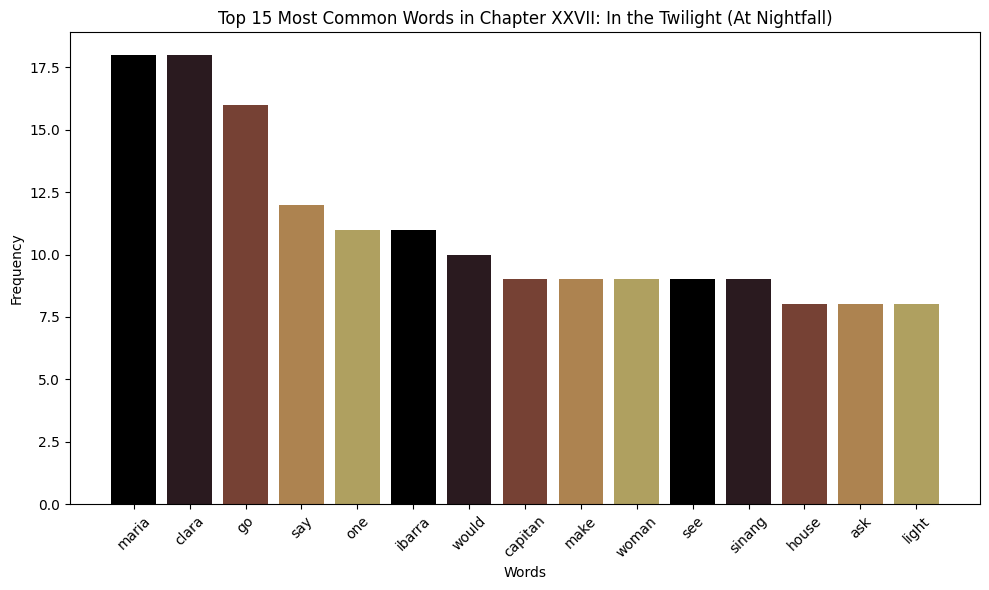

In [ ]:
# Bar Chart Visualization

mycolors = ["#000000", "#2a1a1f", "#764134", "#ad8350", "#afa060"]

import matplotlib.pyplot as plt

words = [word for word, freq in top_15_words]
counts = [freq for word, freq in top_15_words]

plt.figure(figsize=(10, 6))

plt.bar(words, counts, color=mycolors * 3)

plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Top 15 Most Common Words in Chapter XXVII: In the Twilight (At Nightfall)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

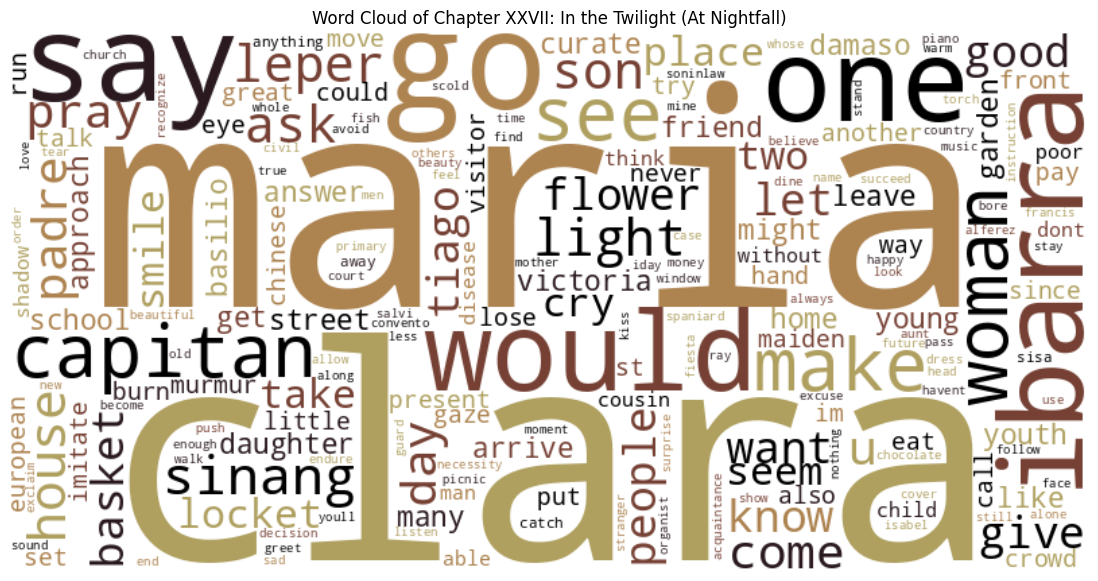

In [ ]:
# Word Cloud Visualization

def custom_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return random.choice(mycolors)
from wordcloud import WordCloud

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color="white",
    color_func=custom_color_func
).generate_from_frequencies(chap27_word_frequency)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Chapter XXVII: In the Twilight (At Nightfall)")
plt.show()

# Part IV - Extractive Summarization

*This uses the minimally cleaned, **normalized Full Chapter Text** from `chap27_normalized`*

### Implementing Position-Aware Logic for extracting sentences appearing in the middle-end (positions where key ideas are located)

In [ ]:
sentences = sent_tokenize(chap27_normalized)
num_sentences = len(sentences)

TF-IDF is used for identifying which sentences contain meaningful and rare terms

In [ ]:
vectorizer = TfidfVectorizer(stop_words="english")
tfidf_matrix = vectorizer.fit_transform(sentences)

sentence_scores = tfidf_matrix.sum(axis=1).A1

Adding weights to sentences based on their positions in the text

In [ ]:
for i in range(num_sentences):
    position_ratio = i / num_sentences

    # Boost middle-to-end sentences
    if position_ratio > 0.5:
        sentence_scores[i] += 0.3

    # Strong boost near the end (climax)
    if position_ratio > 0.75:
        sentence_scores[i] += 0.6

Extracting the top sentences

In [ ]:
top_n = 5
top_indices = np.argsort(sentence_scores)[-top_n:]
top_indices.sort()

summary = " ".join(sentences[i] for i in top_indices)

Checking the output

In [ ]:
print("Chapter XXVII – In the Twilight (At Nightfall) Extractive Summary:\n")
print(textwrap.fill(summary, width=80))

Chapter XXVII – In the Twilight (At Nightfall) Extractive Summary:

It had called him, “The cultivated young gentleman and rich capitalist;” two
lines further on, “The distinguished philanthropist;” in the following
paragraph, “The disciple of Minerva who had gone to the mother country to pay
his respects to the true home of the arts and sciences;” and a little further
on, “The Filipino Spaniard.” Capitan Tiago burned with generous zeal to imitate
him and wondered whether he ought not to erect a convento at his own expense.
Capitan Tiago had arrived on the day before the fiesta and as his daughter
kissed his hand, had presented her with a beautiful locket set with diamonds and
emeralds, containing a sliver from St. Peter’s boat, in which Our Savior sat
during the fishing. “But come back quickly,” said Capitan Tiago to his daughter,
when she asked his permission, “for you know that Padre Damaso, who has just
arrived, will dine with us.” Then turning to Ibarra, who had become thoughtful,

# Part V - Identifying Themes (Topic Modeling)

*This uses the cleaned, **Tokenized Sentences** from `chap27_sentences`*

In [ ]:
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.9, # ignore very common terms
    min_df=2 # ignore very rare terms
)

tfidf_matrix = tfidf_vectorizer.fit_transform(chap27_sentences)

In [ ]:
from sklearn.decomposition import NMF

num_topics = 4

nmf_model = NMF(
    n_components=num_topics,
    random_state=42
)

nmf_topics = nmf_model.fit_transform(tfidf_matrix)

In [ ]:
feature_names = tfidf_vectorizer.get_feature_names_out()

num_top_words = 10

for topic_idx, topic in enumerate(nmf_model.components_):
    top_words = [feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]
    print(f"\nTheme {topic_idx + 1}:")
    print(", ".join(top_words))


Theme 1:
clara, maria, ask, go, victoria, follow, friend, locket, surprise, isabel

Theme 2:
one, ibarra, give, say, would, make, capitan, go, sinang, come

Theme 3:
see, light, might, convento, home, havent, move, raise, pay, youll

Theme 4:
son, pray, let, separate, leper, basilio, garden, flower, catch, woman


### Labeling Each Theme

**Theme 1** – **Maria Clara's Social Relationships and Interactions**  
Keywords: *clara*, *maria*, *victoria*, *friend*, *locket*, *surprise*

**Theme 2** – **Ibarra, Capitan Tiago, and Social Obligations**

Keywords: *ibarra*, *capitan*, *go*, *come*, *make*

**Theme 3** – **Fiesta Atmosphere and Public Display**

Keywords: *convento*, *home*, *light*, *pay*, *see*

**Theme 4** – **Suffering, Compassion, and Moral Conflict**  
Keywords: *pray*, *leper*, *garden*, *basilio*, *separate*